# Linear Models

The goal of the notebook is to use machine learning to automatically determine features for a linear model.  Linear models are interpretable since we know how each feature affects the prediction.  In this example, we will be using the synthetic [Employee Churn Dataset](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) to predict if an employee will churn.

## Steps

1. Import and clean data
2. Train baseline GLM
3. Use decision trees to determine feature engineering
4. Train GLM with engineered features

## Step 1. Import and Clean Data

We will start by importing the data and splitting the data into a train and validation set.  We will use the validation set to see how well the model generalizes on new data.

In [1]:
import h2o 
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.2" 2019-07-16; Java(TM) SE Runtime Environment (build 12.0.2+10); Java HotSpot(TM) 64-Bit Server VM (build 12.0.2+10, mixed mode, sharing)
  Starting server from /Users/megankurka/env2/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpn_uidrfc
  JVM stdout: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpn_uidrfc/h2o_megankurka_started_from_python.out
  JVM stderr: /var/folders/fk/z2fjbsq163scfcsq9fhsw7r00000gn/T/tmpn_uidrfc/h2o_megankurka_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.4
H2O cluster version age:,4 months and 9 days !!!
H2O cluster name:,H2O_from_python_megankurka_2cnqwt
H2O cluster total nodes:,1
H2O cluster free memory:,4 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster status:,"accepting new members, healthy"


In [2]:
df = h2o.import_file("../../../../Data/EmployeeChurn/WA_Fn-UseC_-HR-Employee-Attrition.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
df.head()

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8
36,No,Travel_Rarely,1299,Research & Development,27,3,Medical,1,13,3,Male,94,3,2,Healthcare Representative,3,Married,5237,16577,6,Y,No,13,3,2,80,2,17,3,2,7,7,7,7


In [4]:
train, valid = df.split_frame(seed=1234, destination_frames=["train.hex", "valid.hex"])

In [5]:
print("# of observations in train: {}".format(train.nrow))
print("# of observations in valid: {}".format(valid.nrow))

# of observations in train: 1107
# of observations in valid: 363


## Step 2. Train Baseline GLM Model

Now that we have split our data into training and validation, we will build our baseline GLM.  For this GLM, we will use the raw data (no feature engineering). 

We set `lambda_search` to True so that H2O does an automatic and effecient search to find the optimal lambda (regularization strength) parameter (see: <http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/lambda_search.html>). 

In [6]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [7]:
# remove any redundant or constant columns
x = [i for i in train.col_names if i not in ["DailyRate", "HourlyRate", "Over18", "EmployeeCount", "EmployeeNumber"]]

In [8]:
baseline_glm = H2OGeneralizedLinearEstimator(model_id="baseline_glm.hex",
                                             family="binomial",
                                             lambda_search=True,
                                             nfolds=5, 
                                             seed=1234
                                            )
baseline_glm.train(y="Attrition", x=x, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
print("Training AUC: {0:.5f}".format(baseline_glm.auc(train = True)))
print("Cross Validation AUC: {0:.5f}".format(baseline_glm.auc(xval = True)))
print("Validation AUC: {0:.5f}".format(baseline_glm.auc(valid = True)))

Training AUC: 0.86548
Cross Validation AUC: 0.83428
Validation AUC: 0.85149


Our model does slightly better on the training dataset (which is to be expected).

The plot of coefficients shows us that the main drivers for attrition are:

* working overtime
* being a Laboratory Technician
* traveling frequently

/Users/megankurka/env2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


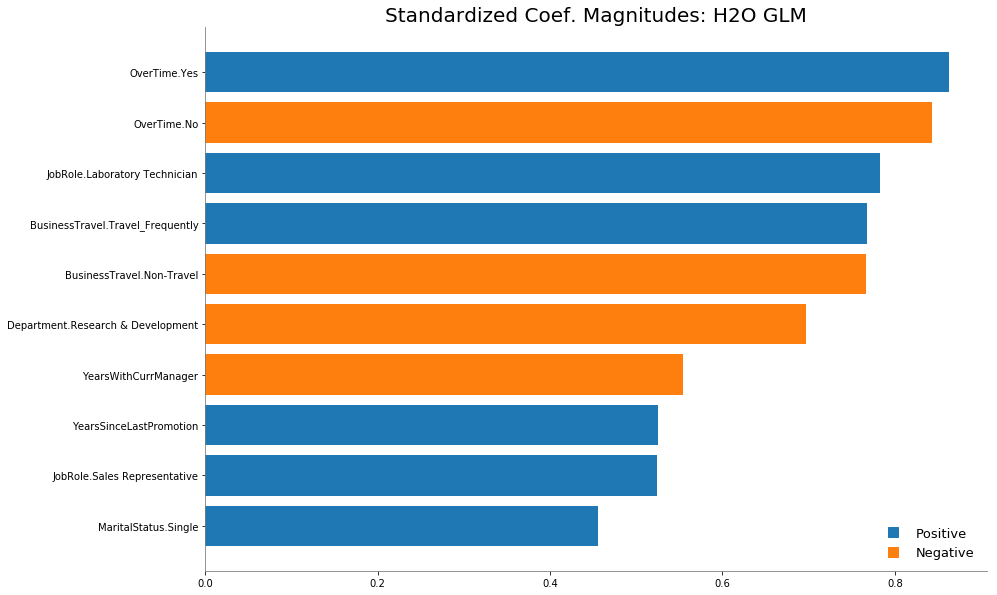

In [10]:
%matplotlib inline
baseline_glm.std_coef_plot(num_of_features=10)

## Step 3: Feature Engineering

Generalized Linear Models are very interpretable but can result in lower accuracy because they cannot inherently handle interactions between features or nonlinear relationships between features and the prediction.

The two common ways to handle this are: 

* bin numeric features
* add interaction terms (multiply/divide numeric columns)

### Adding Bins

We will first train a default XGBoost model to explain why binning our numeric columns may be helpful.

In [11]:
from h2o.estimators.xgboost import H2OXGBoostEstimator
numeric_cols = [k for k, v in train[x].types.items() if v in ['int', 'real']]

xgb_numeric = H2OXGBoostEstimator(model_id = "xgb_numeric.hex")
xgb_numeric.train(y="Attrition", x=numeric_cols, training_frame=train)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


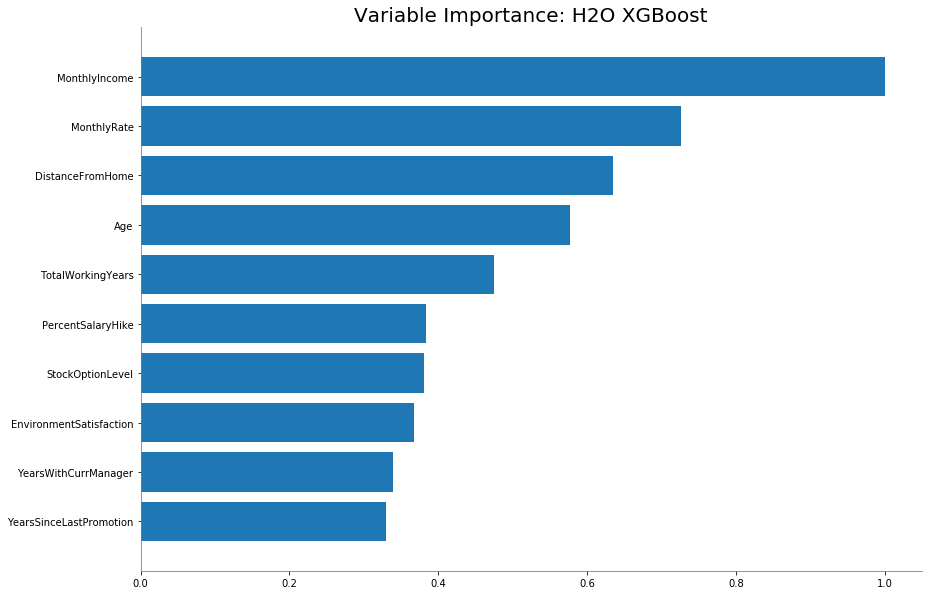

In [12]:
xgb_numeric.varimp_plot()

For the top numeric variables, we can see that all of them have non-linear relationships with the prediction.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependencePlot progress: |█████████████████████████████████████████| 100%


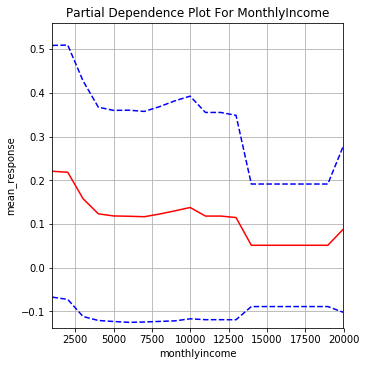

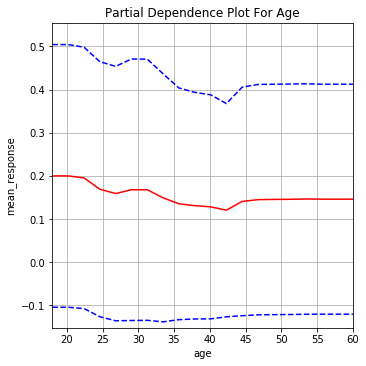

In [13]:
xgb_numeric.partial_plot(train, cols=["MonthlyIncome"], figsize=(5, 5));
xgb_numeric.partial_plot(train, cols=["Age"], figsize=(5, 5));

This means that the linear model is not picking up on the non-linear relationships between these variables.  To fix this, we will add a new column of the binned numeric feature.

This is essentially like converting a numeric column to categorical like "Low", "Medium", "High".  It allows the linear model to assign different coefficients for different ranges of the numeric variable. 

For example, taking a look at the Monthly Income PDP, we would think that the model may find that: 

* low monthly income leads to higher likelihood of attrition
* medium monthly income leads to lower likelihood of attrition
* high monthly income leads to higher likelihood of attrition

Our baseline linear model was not able to pick up on that and found a negative relationship between the monthly income and attrition. 

The code below adds the binned numeric column to our dataset.

If the number of unique values in the categorical is less than 20, then we simply convert the numeric column to categorical.  If the number of unique values is greater than 20, then we bin the numeric column by deciles.

In [14]:
# add bins
for i in numeric_cols:
    new_col_name = "{}_Binned".format(i)
    num_unique_values = train[i].unique().nrow
    
    if num_unique_values < 20:
        train[new_col_name]=train[i].asfactor()
        valid[new_col_name]=valid[i].asfactor()
    else:
        breaks = train[i].quantile(prob=[x * 0.1 for x in range(11)])
        breaks = list(breaks.as_data_frame().iloc[:, 1])
        train[new_col_name]=train[i].cut(breaks, dig_lab=10)
        valid[new_col_name]=valid[i].cut(breaks, dig_lab=10)

In [15]:
train.head()

Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Age_Binned,DistanceFromHome_Binned,Education_Binned,EnvironmentSatisfaction_Binned,JobInvolvement_Binned,JobLevel_Binned,JobSatisfaction_Binned,MonthlyIncome_Binned,MonthlyRate_Binned,NumCompaniesWorked_Binned,PercentSalaryHike_Binned,PerformanceRating_Binned,RelationshipSatisfaction_Binned,StandardHours_Binned,StockOptionLevel_Binned,TotalWorkingYears_Binned,TrainingTimesLastYear_Binned,WorkLifeBalance_Binned,YearsAtCompany_Binned,YearsInCurrentRole_Binned,YearsSinceLastPromotion_Binned,YearsWithCurrManager_Binned
41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,"(38.0,41.0]",,2,2,3,2,4,"(5844.2,7123.2]","(19369.0,21781.0]",8,11,3,1,80,0,"(7.0,8.0]",0,1,"(5.0,7.0]",4,0,5
49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,"(45.0,51.0]","(7.0,9.0]",1,3,2,2,2,"(4978.0,5844.2]","(24105.0,26999.0]",1,23,4,4,80,1,"(8.0,10.0]",3,3,"(9.0,10.0]",7,1,7
37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,"(36.0,38.0]","(1.0,2.0]",2,4,2,1,3,"(1009.0,2309.4]","(2094.0,4658.0]",6,15,3,2,80,0,"(5.0,7.0]",3,3,,0,0,0
27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,"(26.0,29.0]","(1.0,2.0]",1,1,3,1,2,"(3344.6,4270.8]","(14470.0,17001.0]",9,12,3,4,80,1,"(5.0,7.0]",3,3,"(1.0,2.0]",2,2,2
32,No,Travel_Frequently,1005,Research & Development,2,2,Life Sciences,1,8,4,Male,79,3,1,Laboratory Technician,4,Single,3068,11864,0,Y,No,13,3,3,80,0,8,2,2,7,7,3,6,"(31.0,34.0]","(1.0,2.0]",2,4,3,1,4,"(2708.2,3344.6]","(9489.8,11916.8]",0,13,3,3,80,0,"(7.0,8.0]",2,2,"(5.0,7.0]",7,3,6
59,No,Travel_Rarely,1324,Research & Development,3,3,Medical,1,10,3,Female,81,4,1,Laboratory Technician,1,Married,2670,9964,4,Y,Yes,20,4,1,80,3,12,3,2,1,0,0,0,"(51.0,60.0]","(2.0,3.0]",3,3,4,1,1,"(2309.4,2708.2]","(9489.8,11916.8]",4,20,4,1,80,3,"(10.0,13.0]",3,2,"(0.0,1.0]",0,0,0
30,No,Travel_Rarely,1358,Research & Development,24,1,Life Sciences,1,11,4,Male,67,3,1,Laboratory Technician,3,Divorced,2693,13335,1,Y,No,22,4,2,80,1,1,2,3,1,0,0,0,"(29.0,31.0]","(23.4,29.0]",1,4,3,1,3,"(2309.4,2708.2]","(11916.8,14470.0]",1,22,4,2,80,1,"(0.0,3.0]",2,3,"(0.0,1.0]",0,0,0
38,No,Travel_Frequently,216,Research & Development,23,3,Life Sciences,1,12,4,Male,44,2,3,Manufacturing Director,3,Single,9526,8787,0,Y,No,21,4,2,80,0,10,2,3,9,7,1,8,"(36.0,38.0]","(17.0,23.4]",3,4,2,3,3,"(7123.2,9980.8]","(7068.4,9489.8]",0,21,4,2,80,0,"(8.0,10.0]",2,3,"(7.0,9.0]",7,1,8
35,No,Travel_Rarely,809,Research & Development,16,3,Medical,1,14,1,Male,84,4,1,Laboratory Technician,2,Married,2426,16479,0,Y,No,13,3,3,80,1,6,5,3,5,4,0,3,"(34.0,36.0]","(10.2,17.0]",3,1,4,1,2,"(2309.4,2708.2]","(14470.0,17001.0]",0,13,3,3,80,1,"(5.0,7.0]",5,3,"(3.0,5.0]",4,0,3
29,No,Travel_Rarely,153,Research & Development,15,2,Life Sciences,1,15,4,Female,49,2,2,Laboratory Technician,3,Single,4193,12682,0,Y,Yes,12,3,4,80,0,10,3,3,9,5,0,8,"(26.0,29.0]","(10.2,17.0]",2,4,2,2,3,"(3344.6,4270.8]","(11916.8,14470.0]",0,12,3,4,80,0,"(8.0,10.0]",3,3,"(7.0,9.0]",5,0,8


### Adding Interaction Terms

Now we will add interaction terms like multiplying two numeric columns or combining two categorical columns.

To determine which column pairs we should use, we will use an XGBoost model trained on all numeric and all categorical features.  If the decision tree splits on two features sequentially, an interaction term may potentially improve the model.

In [16]:
xgb = H2OXGBoostEstimator(model_id = "xgb.hex", 
                          ntrees = 1, 
                          max_depth = 3)
xgb.train(y="Attrition", x=x, training_frame=train)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [17]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(decision_tree, image_file_path):
    # Download MOJO
    mojo_path = decision_tree.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree 0 -i", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    
    return Image(image_file_path)

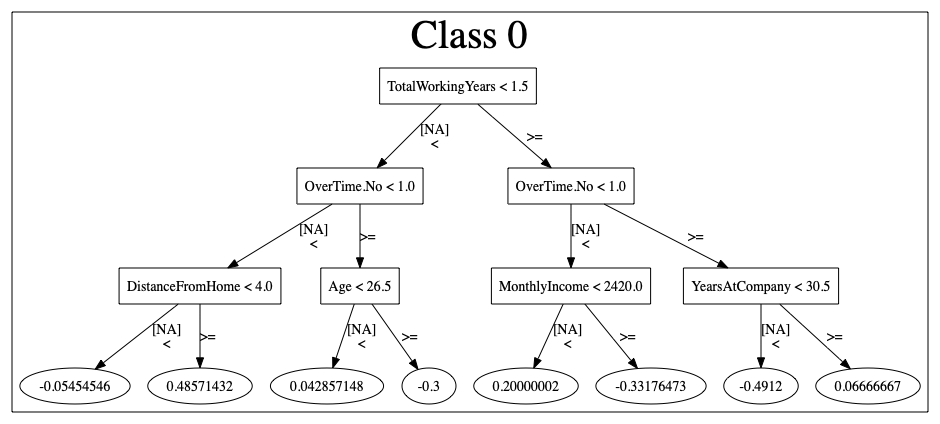

In [18]:
generateTreeImage(xgb, "./xgb_tree.png")

Our XGBoost model shows that the following interaction terms could be important:

In [19]:
interaction_pairs = [["TotalWorkingYears", "OverTime"], 
                     ["OverTime", "DistanceFromHome"],
                     ["OverTime", "Age"],
                     ["OverTime", "MonthlyIncome"], 
                     ["OverTime", "YearsAtCompany"]]

In [20]:
for i in interaction_pairs:
    a = i[0]
    b = i[1]
    new_col = "{}:{}".format(a, b)
    
    if train.types.get(a) in ["int", "real"]:
        a = "{}_Binned".format(a)
    if train.types.get(b) in ["int", "real"]:
        b = "{}_Binned".format(b)
        
    train[new_col] = h2o.interaction(train, 
                                     factors=[a,b],
                                     pairwise=True,
                                     max_factors=10000,
                                     min_occurrence=10
                                    )
    
    valid[new_col] = h2o.interaction(valid, 
                                     factors=[a,b],
                                     pairwise=True,
                                     max_factors=10000,
                                     min_occurrence=10
                                    )

Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%
Interactions progress: |██████████████████████████████████████████████████| 100%


## Step 4: Train GLM with Engineered Features

Now we will train our GLM model again but this time we will include our binned features and interaction terms.

In [21]:
x = [i for i in train.col_names if i not in ["DailyRate", "HourlyRate", "Over18", "EmployeeCount", "EmployeeNumber"]]

In [22]:
fe_glm = H2OGeneralizedLinearEstimator(model_id="fe_glm.hex",
                                       family="binomial",
                                       lambda_search=True,
                                       nfolds=5, 
                                       seed=1234
                                      )
fe_glm.train(y="Attrition", x=x, training_frame=train, validation_frame=valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [23]:
print("Training AUC: {0:.5f}".format(baseline_glm.auc(train = True)))
print("Cross Validation AUC: {0:.5f}".format(baseline_glm.auc(xval = True)))
print("Validation AUC: {0:.5f}".format(baseline_glm.auc(valid = True)))

Training AUC: 0.86548
Cross Validation AUC: 0.83428
Validation AUC: 0.85149


In [24]:
print("Feature Engineering Training AUC: {0:.5f}".format(fe_glm.auc(train = True)))
print("Feature Engineering Cross Validation AUC: {0:.5f}".format(fe_glm.auc(xval = True)))
print("Feature Engineering Validation AUC: {0:.5f}".format(fe_glm.auc(valid = True)))

Feature Engineering Training AUC: 0.90557
Feature Engineering Cross Validation AUC: 0.84498
Feature Engineering Validation AUC: 0.85395


We can see that the performance of our model has improved and some of our new features like: 

* `EnvironmentSatisfaction` binned
* Interaction between `OverTime` and `Age`
* `JobLevel` binned
* `YearsWithCurrManager_Binned`

/Users/megankurka/env2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


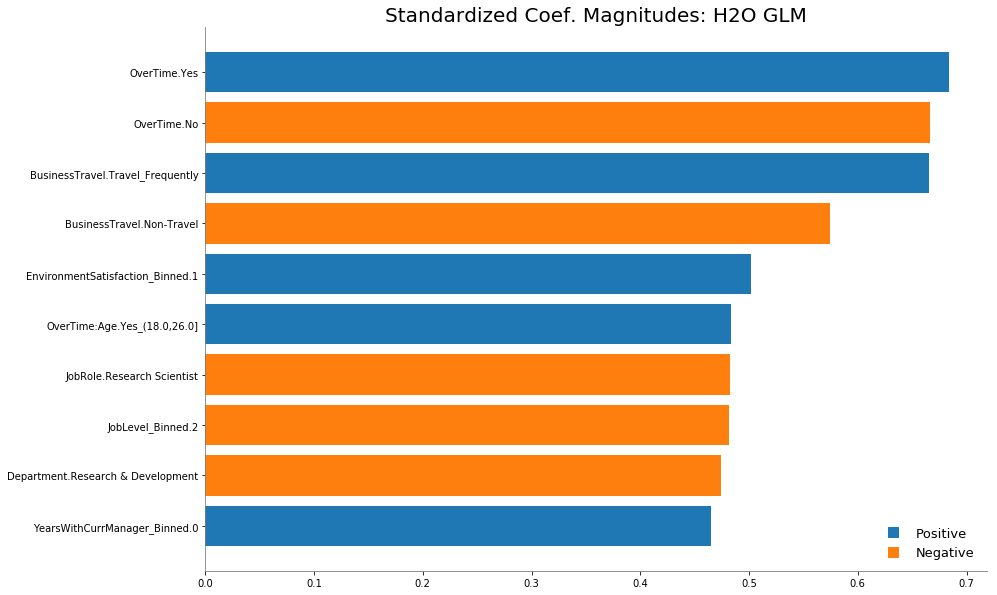

In [25]:
fe_glm.std_coef_plot(num_of_features=10)

In [26]:
h2o.cluster().shutdown()

H2O session _sid_b993 closed.
